# Global Toolbox

In [1]:
import warnings

warnings.filterwarnings("ignore")

import numpy as np

seed = 356
np.random.seed(seed)
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import sklearn
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import (
    BaggingClassifier,
    RandomForestClassifier,
    BaggingRegressor,
    RandomForestRegressor,
)
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve
from IPython.display import Image
import pandas as pd
from functools import reduce

# !pip install xgboost
from xgboost import XGBClassifier

# !pip install gdown
import gdown

# !pip install pydotplus
import pydotplus
from tqdm import tqdm

print("The version of my sklearn package is", sklearn.__version__)


The version of my sklearn package is 1.4.1.post1


# Part 1: Basis Expansion
$f(X) = \sum_{m=1}^{M} \beta_m h_m (X)$
### Piecewise fitting using conditional basis (with two knots _i.e._, $\varepsilon_{1}$ and $\varepsilon_{2}$)


### Initializing coordinates and regions:

In [2]:
# Axes limits and knots
x_min, x_knot_1, x_knot_2, x_max = -1, 1.5, 4.5, 7

# Points generated from a cosine function with normal noise
x_true = np.linspace(x_min, x_max, 50)
y_true = np.cos(x_true)
y_obs = y_true + np.random.normal(scale=0.5, size=len(x_true))

# Get x-y coordinates per region
x_region_1 = x_true[x_true <= x_knot_1]
x_region_2 = x_true[(x_knot_1 < x_true) & (x_true < x_knot_2)]
x_region_3 = x_true[x_true >= x_knot_2]
y_region_1 = y_true[x_true <= x_knot_1]
y_region_2 = y_true[(x_knot_1 < x_true) & (x_true < x_knot_2)]
y_region_3 = y_true[x_true >= x_knot_2]


### Piecewise constant fitting with the following basis functions:

$h_{1}(X)=I(X<\varepsilon_{1})\\$
$h_{2}(X)=I(\varepsilon_{1}\leq X < \varepsilon_2 )\\$
$h_{3}(X)=I(\varepsilon_{2}\leq X)\\$

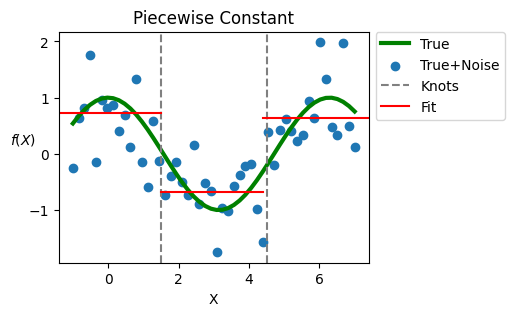

In [3]:
# Plot cosine line and noisy data
plt.figure(figsize=(4, 3))
plt.plot(x_true, y_true, linewidth=3, c="g", label="True")
plt.scatter(x_true, y_obs, label="True+Noise")

# Plot knots
plt.axvline(x=x_knot_1, c="gray", ls="--", label="Knots")
plt.axvline(x=x_knot_2, c="gray", ls="--")

# Plot piecewise constant fits
plt.axhline(y=y_region_1.mean(), c="r", xmin=0, xmax=0.33, label="Fit")
plt.axhline(y=y_region_2.mean(), c="r", xmin=0.33, xmax=0.66)
plt.axhline(y=y_region_3.mean(), c="r", xmin=0.66, xmax=1)
plt.title("Piecewise Constant")
plt.legend(bbox_to_anchor=(1, 1.03))
plt.xlabel("X")
plt.ylabel("$f(X)$", rotation=0)
plt.show()


### Piecewise linear fitting with the following basis functions:

$h_{1}(X)=I(X<\varepsilon_{1})\\$
$h_{2}(X)=I(\varepsilon_{1}\leq X < \varepsilon_2 )\\$
$h_{3}(X)=I(\varepsilon_{2}\leq X)\\$
$h_{4}(X)=h_1(X)X\\$
$h_{5}(X)=h_2(X)X\\$
$h_{6}(X)=h_3(X)X\\$

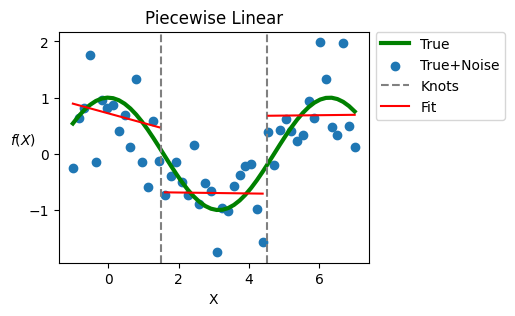

In [4]:
# Calculate OLS coefficients from regression anatomy
beta_region_1 = (y_region_1 - y_region_1.mean()).dot(x_region_1) / (x_region_1**2).sum()
beta_region_2 = (y_region_2 - y_region_2.mean()).dot(x_region_2) / (x_region_2**2).sum()
beta_region_3 = (y_region_3 - y_region_3.mean()).dot(x_region_3) / (x_region_3**2).sum()

# Calculate regression fitted values
y_hat_region_1 = beta_region_1 * x_region_1 + y_region_1.mean()
y_hat_region_2 = beta_region_2 * x_region_2 + y_region_2.mean()
y_hat_region_3 = beta_region_3 * x_region_3 + y_region_3.mean()

# Plot cosine line and noisy data
plt.figure(figsize=(4, 3))
plt.plot(x_true, y_true, linewidth=3, c="g", label="True")
plt.scatter(x_true, y_obs, label="True+Noise")

# Plot knots
plt.axvline(x=x_knot_1, c="gray", ls="--", label="Knots")
plt.axvline(x=x_knot_2, c="gray", ls="--")

# Plot piecewise linear fits
plt.plot(x_region_1, y_hat_region_1, c="r", label="Fit")
plt.plot(x_region_2, y_hat_region_2, c="r")
plt.plot(x_region_3, y_hat_region_3, c="r")
plt.title("Piecewise Linear")
plt.legend(bbox_to_anchor=(1, 1.03))
plt.xlabel("X")
plt.ylabel("$f(X)$", rotation=0)
plt.show()


### Continuous piecewise linear fitting with the following basis functions:

$h_{1}(X)=1\\$
$h_{2}(X)=X\\$
$h_{3}(X)=(X-\varepsilon_1)_+\\$
$h_{4}(X)=(X-\varepsilon_2)_+\\$

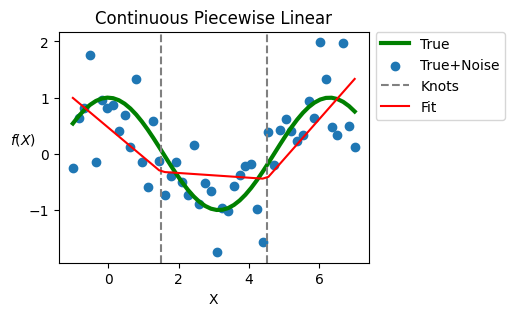

In [5]:
# Construct H
# Continuity is enforced at the knots through incorporating proper constraints into the basis functions
h1 = np.ones_like(x_true)
h2 = np.copy(x_true)
h3 = np.where(x_true < x_knot_1, 0, x_true - x_knot_1)
h4 = np.where(x_true < x_knot_2, 0, x_true - x_knot_2)
H = np.vstack((h1, h2, h3, h4)).T

# Fit basis expansion via OLS
HH = H.T @ H
beta = np.linalg.solve(HH, H.T @ y_obs)
y_hat = H @ beta

# Plot cosine line and noisy data
plt.figure(figsize=(4, 3))
plt.plot(x_true, y_true, linewidth=3, c="g", label="True")
plt.scatter(x_true, y_obs, label="True+Noise")

# Plot knots
plt.axvline(x=x_knot_1, c="gray", ls="--", label="Knots")
plt.axvline(x=x_knot_2, c="gray", ls="--")

# Plot piecewise linear fits
plt.plot(x_true, y_hat, c="r", label="Fit")
plt.title("Continuous Piecewise Linear")
plt.legend(bbox_to_anchor=(1, 1.03))
plt.xlabel("X")
plt.ylabel("$f(X)$", rotation=0)
plt.show()


### Continuous piecewise polynomial fitting:
Piecewise polynomials, even those continuous at the knots, tend not to be smooth: they rapidly change the slope at the knots. To prevent this and increase their smoothness, it is enough to increase the order of the local polynomial and require the first two derivatives on both sides of the knot to be the same. A function that is continuous and has continuous first and second derivatives is called a cubic spline and can be represented with the following basis functions:

$h_{1}(X)=1\\$
$h_{2}(X)=X\\$
$h_{3}(X)=X^2\\$
$h_{4}(X)=X^3\\$
$h_{5}(X)=(X-\varepsilon_1)_+^3\\$
$h_{6}(X)=(X-\varepsilon_2)_+^3\\$

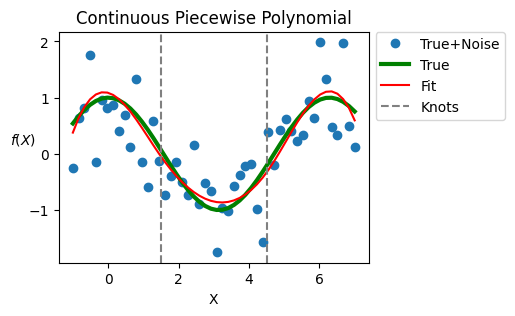

In [6]:
# Construct H
h1 = np.ones_like(
    x_true
)  # `ones_like` returns an array of ones with the same shape and type as `x_true`
h2 = np.copy(x_true)
h3 = h2**2
h4 = h2**3
h5 = np.where(x_true < x_knot_1, 0, (x_true - x_knot_1) ** 3)
h6 = np.where(x_true < x_knot_2, 0, (x_true - x_knot_2) ** 3)
H = np.vstack((h1, h2, h3, h4, h5, h6)).T

# Fit basis expansion via OLS
HH = H.T @ H
beta = np.linalg.solve(HH, H.T @ y_true)
y_hat = H @ beta

# Plot simulated data and cubic spline
plt.figure(figsize=(4, 3))
plt.plot(x_true, y_obs, "o", label="True+Noise")
plt.plot(x_true, y_true, linewidth=3, color="g", label="True")
plt.plot(x_true, y_hat, color="r", label="Fit")
plt.title("Continuous Piecewise Polynomial")

# Plot knots
plt.axvline(x=x_knot_1, c="gray", ls="--", label="Knots")
plt.axvline(x=x_knot_2, c="gray", ls="--")
plt.legend(bbox_to_anchor=(1, 1.03))
plt.xlabel("X")
plt.ylabel("$f(X)$", rotation=0)
plt.show()


# Part 2: Decision Trees

Review Scikit-Learn [Decision Trees](https://scikit-learn.org/stable/modules/tree.html).

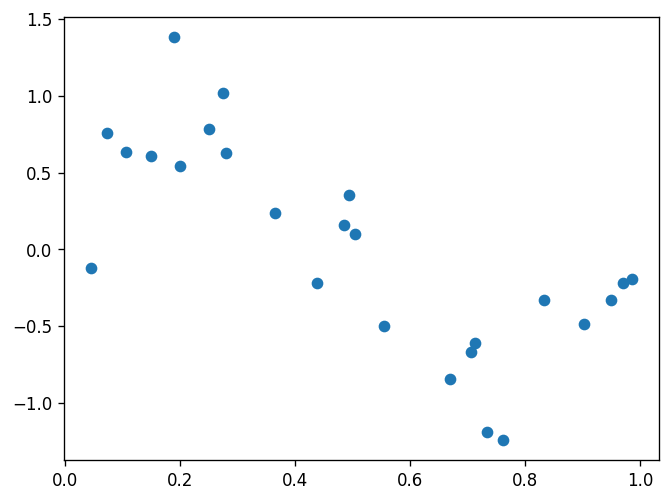

In [7]:
# Make some fake data
def make_regression_data(n=25):
    x = np.random.uniform(size=(n, 1))
    e = np.random.normal(0, 0.3, size=x.shape)  # some noise
    y = np.sin(2 * np.pi * x) + e
    return (x, y.ravel())


x, y = make_regression_data()
fig, ax = plt.subplots(dpi=120)
plt.scatter(x, y)
plt.show()


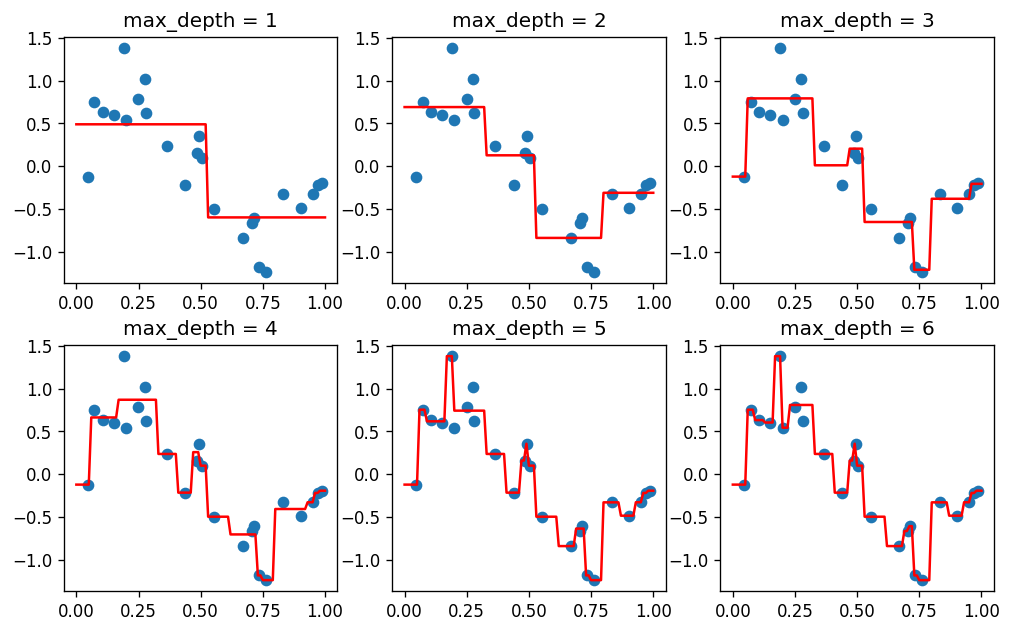

In [8]:
# Fit a regression tree to this data
# With varying max depth
# To see how this tree grows

depths = np.arange(1, 7)
fig, ax = plt.subplots(dpi=120, nrows=2, ncols=3, figsize=(10, 6))
plt.subplots_adjust(hspace=0.25)
ax = ax.ravel()  # flattens the ax variable

newx = np.linspace(0, 1, 101).reshape(-1, 1)

for d, a in zip(depths, ax):
    reg = DecisionTreeRegressor(max_depth=d)
    reg.fit(x, y)

    ypred = reg.predict(newx)
    a.scatter(x, y)
    a.plot(newx, ypred, color="red")
    a.set_title(f"max_depth = {d}")


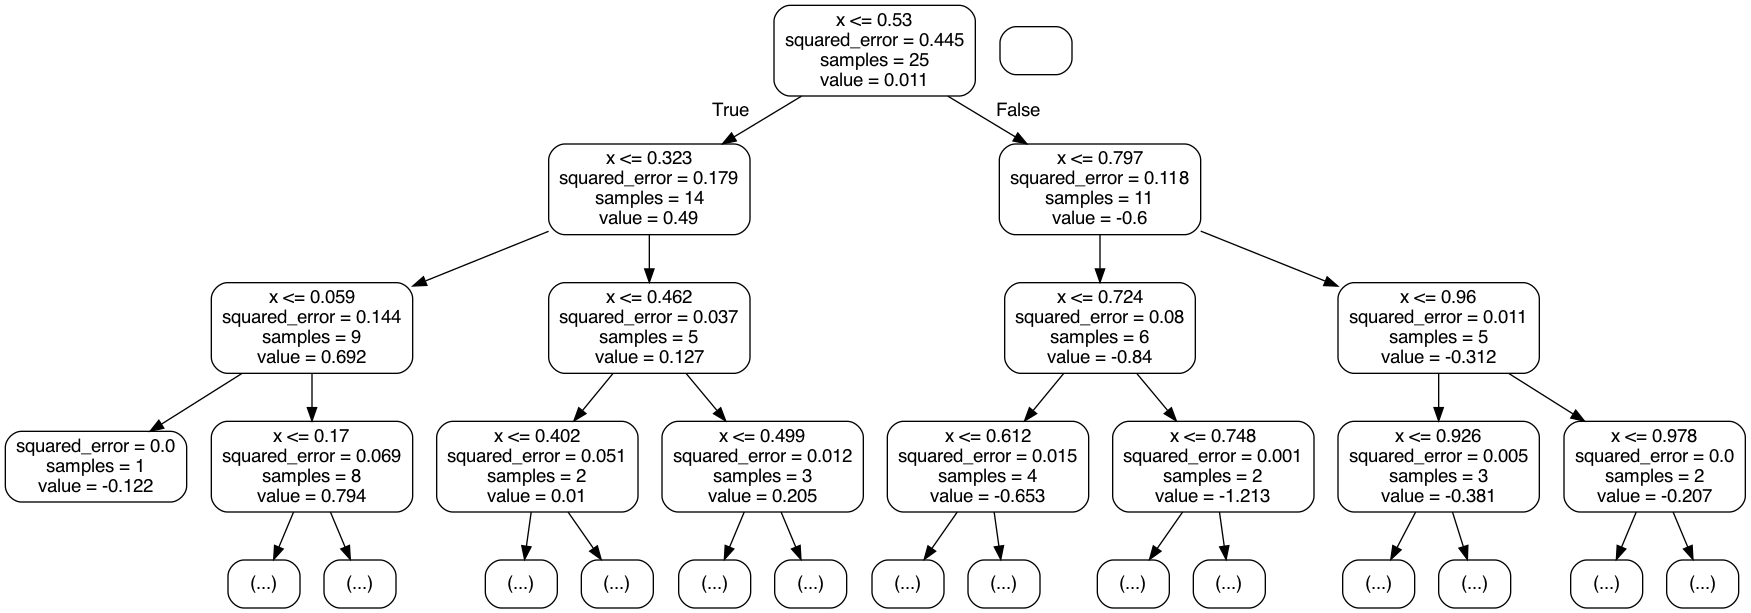

In [9]:
# Create DOT data
dot_data = export_graphviz(
    reg, out_file=None, rounded=True, max_depth=3, feature_names=["x"]
)

# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)

# Show graph
Image(graph.create_png())


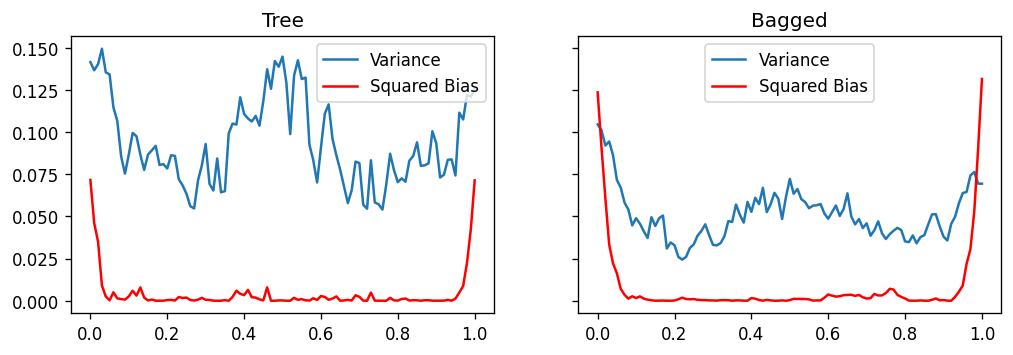

In [10]:
# Let's compare variance of predictions between a tree and a bagged estimator

# Create a tree model and a bagging from these trees
newx = np.linspace(0, 1, 101).reshape(-1, 1)
tree = DecisionTreeRegressor(max_depth=5)
bag1 = BaggingRegressor(
    estimator=DecisionTreeRegressor(max_depth=5), n_estimators=100, n_jobs=-1
)

models = [tree, bag1]
model_names = ["Tree", "Bagged"]

# Create two plots, one for the tree, one for the bagging
fig, ax = plt.subplots(
    dpi=120, nrows=1, ncols=len(models), figsize=(10, 3), sharey=True
)
ax = ax.ravel()  # flattens the ax variable

# Generate 500 runs for each model and calculate bias and variance. This takes a while!
nsim = 50

for axis, model, name in zip(ax, models, model_names):

    # Store the predictions somewhere
    predictions = np.zeros((nsim, newx.shape[0]))

    for i in range(nsim):
        x, y = make_regression_data()
        model.fit(x, y)
        ypred = model.predict(newx)
        predictions[i] = ypred

    # Plot the variance
    axis.plot(newx, predictions.var(axis=0), label="Variance")

    # Plot the bias
    bias = (predictions - np.sin(2 * np.pi * newx.T)).mean(axis=0) ** 2
    axis.plot(newx, bias, color="red", label="Squared Bias")
    axis.set_title(name)
    axis.legend()


The following cell is just the expanded version of the previous cell to make it easier to follow, otherwise they do the same thing.

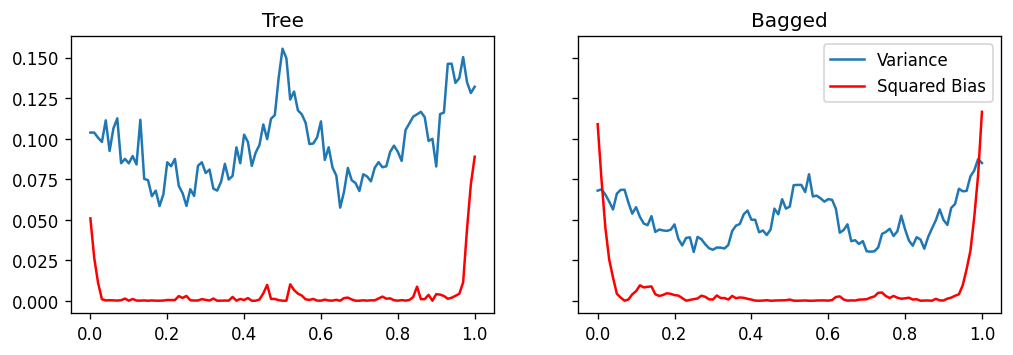

In [11]:
# Let's compare variance of predictions between a tree and a bagged estimator
newx = np.linspace(0, 1, 101).reshape(-1, 1)

# Generate `nsim` runs for each model and calculate bias and variance. This takes a while!
nsim = 50

# Create two plots, one for the tree, one for the bagging
fig, ax = plt.subplots(
    dpi=120, nrows=1, ncols=len(models), figsize=(10, 3), sharey=True
)


################################################### 1st figure
# Create a simple tree model
tree = DecisionTreeRegressor(max_depth=5)
# Initialize an array for predictions
predictions = np.zeros((nsim, newx.shape[0]))

for i in range(nsim):
    x, y = (
        make_regression_data()
    )  # every time get new data from the same data generating process
    tree.fit(x, y)
    ypred = tree.predict(newx)  # here ypred is coming directly from the terminal
    # nodes of the single tree fitted to x and y
    predictions[i] = ypred

# Plot the variance
ax[0].plot(newx, predictions.var(axis=0), label="Variance")

# Plot the bias
bias = (predictions - np.sin(2 * np.pi * newx.T)).mean(axis=0) ** 2
ax[0].plot(newx, bias, color="red", label="Squared Bias")
ax[0].set_title("Tree")


################################################### 2nd figure
# Create a bagging model
bag = BaggingRegressor(DecisionTreeRegressor(max_depth=5), n_estimators=100, n_jobs=-1)
# Initialize an array for predictions
predictions = np.zeros((nsim, newx.shape[0]))

for i in range(nsim):
    x, y = (
        make_regression_data()
    )  # every time get new data from the same data generating process
    bag.fit(x, y)
    ypred = bag.predict(
        newx
    )  # here ypred is coming from averaging individual predictions of
    # random subsets of the original dataset (one tree per random subset)
    predictions[i] = ypred

# Plot the variance
ax[1].plot(newx, predictions.var(axis=0), label="Variance")

# Plot the bias
bias = (predictions - np.sin(2 * np.pi * newx.T)).mean(axis=0) ** 2
ax[1].plot(newx, bias, color="red", label="Squared Bias")
ax[1].set_title("Bagged")
ax[1].legend()

plt.show()


# Part 3: Random Forest

Now we will train a random forest. It is included in the ```sklearn.ensemble``` subpackage, function [```RandomForestClassifier```](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html), so it is straightforward to use. It comes with many parameters, but in general there is a philosophy to follow:

- In a Random Forest we want each tree to be large, and to learn as much as possible from its subset of data. We don't care too much if each tree is overadjusted, as we can always increase the number of trees to take care of this.

- This said, a good idea is to limit the minimum number of samples per leaf when we have few cases (this is not usually a problem in large trees.)

- We might want to limit the minimum impurity decrease to stop growing a tree if not much is happening.

- There is also a class weight to include. It does include one automatically if we use the option ```balanced```.

Let's train one and check the options.

In [12]:
# Define the classifier
bankloan_rf = RandomForestClassifier(
    n_estimators=1000,  # Number of trees to train
    criterion="entropy",  # How to train the trees. Also supports entropy.
    max_depth=None,  # Max depth of the trees. Not necessary to change.
    min_samples_split=2,  # Minimum samples to create a split.
    min_samples_leaf=0.001,  # Minimum samples in a leaf. Accepts fractions for %. This is 0.1% of sample.
    min_weight_fraction_leaf=0.0,  # Same as above, but uses the class weights.
    max_features="sqrt",  # Maximum number of features per split (not tree!) by default is sqrt(vars)
    max_leaf_nodes=None,  # Maximum number of nodes.
    min_impurity_decrease=0.0001,  # Minimum impurity decrease. This is 10^-3.
    bootstrap=True,  # If sample with repetition. For large samples (>100.000) set to false. If False, the whole dataset is used to build each tree.
    oob_score=True,  # If report accuracy with non-selected cases.
    n_jobs=-1,  # Parallel processing. Set to -1 for all cores. Watch your RAM!!
    random_state=seed,  # Seed
    verbose=1,  # If to give info during training. Set to 0 for silent training.
    warm_start=False,  # If train over previously trained tree.
    class_weight="balanced",
)

# These are parameters to limit the growth of the tree. If you need to constrain the growth of the tree, pick one of them.
# max_depth
# min_samples_split
# min_samples_leaf
# min_weight_fraction_leaf
# min_impurity_decrease  # this is more agnostic to the sample size. If you really need to constrain growth, this is preferred


Now we are ready to train. I have created a credit risk dataset that can be used to predict the probability of not paying back a loan (a credit score). We will also split the data into a train and test set.

In [13]:
# Read the file
bankloan_data = pd.read_pickle("BankloanClean.pkl")

# Drop a categorical variable
bankloan_data.drop("Education", inplace=True, axis=1)


The data has the following variables:

- Customer: ID, or unique label, of the borrower (NOT predictive).
-    Age: Age of the borrower in years.
-    Employ: Years at current job.
-    Address: Years at current address.
-    Income: Income in ‘000s USD.
-    Leverage: Debt/Income Ratio.
-    CredDebt: Credit card standing debt.
-    OthDebt: Other debt in ‘000s USD.
-    MonthlyLoad: Monthly percentage from salary used to repay debts.
-    Default: 1 If default has occurred, 0 if not (Target variable).


In [14]:
print(bankloan_data.shape)
bankloan_data.head()


(1489, 10)


,customer,Age,Employ,Address,Income,Leverage,Creddebt,OthDebt,MonthlyLoad,Default
0,10012,28,7,2.0,44.0,17.7,2.99,4.80,0.58,0
1,10017,64,34,17.0,116.0,14.7,5.05,12.00,0.27,0
2,10030,40,20,12.0,61.0,4.8,1.04,1.89,0.13,0
3,10039,30,11,3.0,27.0,34.5,1.75,7.56,1.62,0
4,10069,25,2,2.0,30.0,22.4,0.76,5.96,0.97,1


In [15]:
bankloan_data.describe()


,customer,Age,Employ,Address,Income,Leverage,Creddebt,OthDebt,MonthlyLoad,Default
count,1489.000000,1489.000000,1489.000000,1489.000000,1489.000000,1489.000000,1489.000000,1489.000000,1489.000000,1489.000000
mean,257649.480188,34.003358,6.799866,6.233714,56.898590,9.904835,1.801370,3.664231,0.366850,0.361988
std,139646.983244,12.982437,8.765093,5.987928,55.062182,6.649132,2.340326,4.665854,0.294387,0.480737
min,10012.000000,18.000000,0.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,98410.000000,24.000000,0.000000,2.000000,27.000000,4.800000,0.420000,1.100000,0.150000,0.000000
50%,316013.000000,31.000000,4.000000,5.000000,39.000000,8.500000,0.980000,2.200000,0.290000,0.000000
75%,370695.000000,41.000000,10.000000,9.000000,63.000000,13.500000,2.170000,4.500000,0.500000,1.000000
max,453777.000000,79.000000,63.000000,34.000000,533.000000,40.700000,19.050000,52.650000,2.150000,1.000000


Now we split the data into train and test.

In [16]:
# Split into train and test, fixing seed.
bankloan_train_noWoE, bankloan_test_noWoE = train_test_split(
    bankloan_data.iloc[:, 1:], test_size=0.3, random_state=seed
)


Now we train!

In [17]:
# Train the RF.
bankloan_rf.fit(bankloan_train_noWoE.iloc[:, :-1], bankloan_train_noWoE["Default"])


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    0.6s finished


RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       min_impurity_decrease=0.0001, min_samples_leaf=0.001,
                       n_estimators=1000, n_jobs=-1, oob_score=True,
                       random_state=356, verbose=1)

We can see it used two jobs (two processors are available to me in this computer). It converges very quickly. Let's check how it did, this time we will print a nicer confusion matrix using seaborn, and will plot the ROC curve of the model. 

In [18]:
# Apply the model to the test set.
rf_pred_class_test = bankloan_rf.predict(bankloan_test_noWoE.iloc[:, :-1])
rf_probs_test = bankloan_rf.predict_proba(bankloan_test_noWoE.iloc[:, :-1])


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 1000 out of 1000 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 1000 out of 1000 | elapsed:    0.1s finished


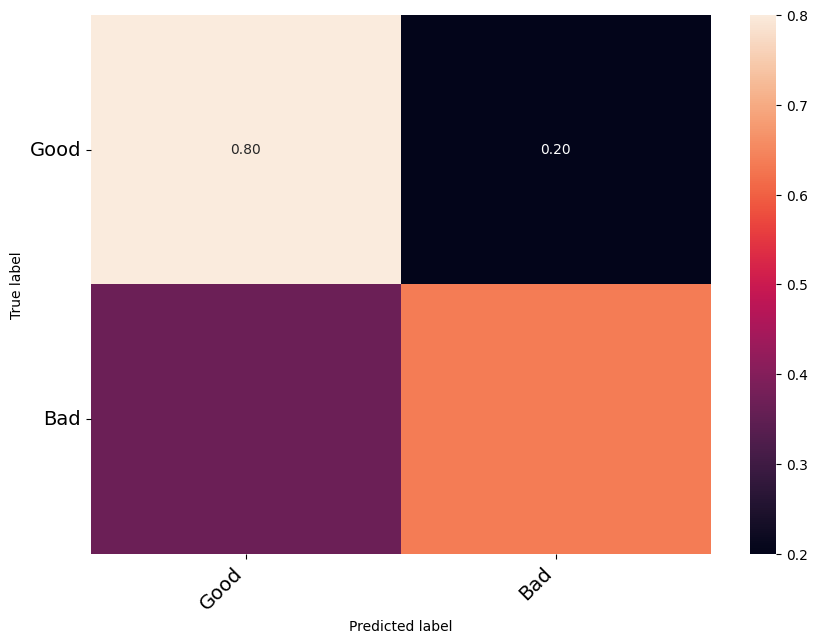

In [19]:
# Calculate confusion matrix
confusion_matrix_rf = confusion_matrix(
    y_true=bankloan_test_noWoE["Default"], y_pred=rf_pred_class_test
)

# Turn matrix to percentages
confusion_matrix_rf = (
    confusion_matrix_rf.astype("float") / confusion_matrix_rf.sum(axis=1)[:, np.newaxis]
)

# Turn to dataframe
df_cm = pd.DataFrame(
    confusion_matrix_rf, index=["Good", "Bad"], columns=["Good", "Bad"]
)

# Parameters of the image
figsize = (10, 7)
fontsize = 14

# Create image
fig = plt.figure(figsize=figsize)
heatmap = sns.heatmap(df_cm, annot=True, fmt=".2f")

# Make it nicer
heatmap.yaxis.set_ticklabels(
    heatmap.yaxis.get_ticklabels(), rotation=0, ha="right", fontsize=fontsize
)
heatmap.xaxis.set_ticklabels(
    heatmap.xaxis.get_ticklabels(), rotation=45, ha="right", fontsize=fontsize
)

# Add labels
plt.ylabel("True label")
plt.xlabel("Predicted label")

# Plot!
plt.show()


[Out-of-Bag (OOB) error](https://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html)

The `RandomForestClassifier` is trained using bootstrap aggregation, where each new tree is fit from a bootstrap sample of the training observations $z_i=(x_i,y_i)$. The out-of-bag (OOB) error is the average error for each $z_i$ calculated using predictions from the trees that do not contain $z_i$ in their respective bootstrap sample. This allows the `RandomForestClassifier` to be fit and validated whilst being trained.

In [20]:
bankloan_rf.oob_score_
# can think of this as validation score


0.7389635316698656

Return the mean accuracy on the given test data and labels:

In [21]:
bankloan_rf.score(bankloan_train_noWoE.iloc[:, :-1], bankloan_train_noWoE["Default"])


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 1000 out of 1000 | elapsed:    0.1s finished


0.9865642994241842

Looks a bit unbalanced, but otherwise ok. It's harder to predict the  defaulters. Now let's see the ROC curve.

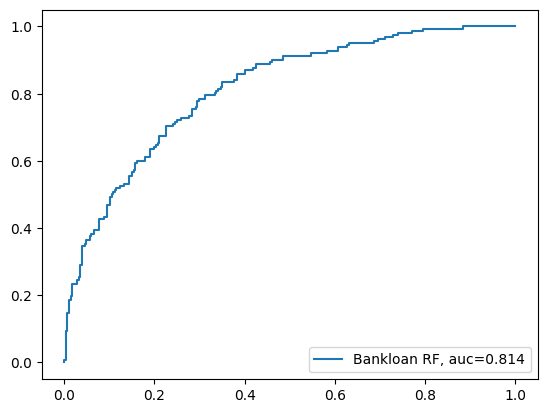

In [22]:
# Calculate the ROC curve points
fpr, tpr, thresholds = roc_curve(bankloan_test_noWoE["Default"], rf_probs_test[:, 1])

# Save the AUC in a variable to display it. Round it first
auc = np.round(
    roc_auc_score(y_true=bankloan_test_noWoE["Default"], y_score=rf_probs_test[:, 1]),
    decimals=3,
)

# Create and show the plot
plt.plot(fpr, tpr, label="Bankloan RF, auc=" + str(auc))
plt.legend(loc=4)
plt.show()


Now, let's print the variable importance. The importance is calculated by averaging the accuracy of trees when the variables is included the tree, and comparing it to when it's NOT included the tree.

[Feature Importances with a Forest of Trees](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html)
also [this](https://towardsdatascience.com/the-mathematics-of-decision-trees-random-forest-and-feature-importance-in-scikit-learn-and-spark-f2861df67e3).

In [23]:
importances = bankloan_rf.feature_importances_
print(bankloan_rf.feature_names_in_)
print(importances)


['Age' 'Employ' 'Address' 'Income' 'Leverage' 'Creddebt' 'OthDebt'
 'MonthlyLoad']
[0.11907703 0.13702174 0.0767042  0.09731063 0.15647126 0.14350941
 0.11130051 0.15860522]


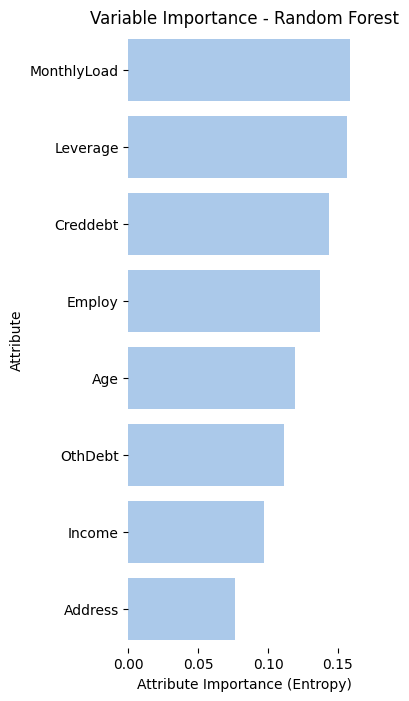

In [24]:
# Plot variable importance
indices = np.argsort(importances)[::-1]

f, ax = plt.subplots(figsize=(3, 8))

plt.title("Variable Importance - Random Forest")
sns.set_color_codes("pastel")

sns.barplot(
    y=[bankloan_rf.feature_names_in_[i] for i in indices],
    x=importances[indices],
    label="Total",
    color="b",
)
# or
# sns.barplot(y=[bankloan_train_noWoE.iloc[:, :-1].columns[i] for i in indices], x=importances[indices], label="Total", color="b")

ax.set(ylabel="Attribute", xlabel="Attribute Importance (Entropy)")
sns.despine(left=True, bottom=True)


Also take a look at [RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html).

# Part 4: [XGBoosting](https://xgboost.readthedocs.io/en/stable/)

XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable. It implements machine learning algorithms under the Gradient Boosting framework and is an alternative to Random Forest. Now we want to create a series of small trees, which will be poorer in individual performance, but together they will be stronger. Training an XGBoost model is harder, because we need to control the model so it creates small trees, but it performs better in small data, something Random Forests do not necessarily accomplish.

[XGBClassifier Scikit-Learn API](https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBClassifier)

[XGBRegressor Scikit-Learn API](https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBRegressor)

While scikit-learn does have its own implementation of XGB ([```sklearn.ensemble```](https://scikit-learn.org/stable/modules/ensemble.html)), there are a couple of very strong packages out there that implement the algorithm. ```xgboost``` and ```lightgbm``` are two of the best known ones. We will use ```xgboost``` for this lab, available pretty much for every language out there.

The first step is to define a classifier that we will use.

In [25]:
# Define the classifier.

# Specify the learning task and the corresponding learning objective. The objective options are below:
# https://xgboost.readthedocs.io/en/stable/parameter.html#learning-task-parameters

XGB_Bankloan = XGBClassifier(
    max_depth=3,  # Depth of each tree
    learning_rate=0.1,  # How much to shrink error in each subsequent training. Trade-off with no. estimators.
    n_estimators=100,  # How many trees to use, the more the better, but decrease learning rate if many used.
    verbosity=1,  # If to show more errors or not.
    objective="binary:logistic",  # Type of target variable.
    booster="gbtree",  # What to boost. Trees in this case.
    n_jobs=-1,  # Parallel jobs to run. Set your processor number.
    gamma=0.001,  # Minimum loss reduction required to make a further partition on a leaf node of the tree. (Controls growth!)
    subsample=0.632,  # Subsample ratio. Can set lower
    colsample_bytree=1,  # Subsample ratio of columns when constructing each tree.
    colsample_bylevel=1,  # Subsample ratio of columns when constructing each level. 0.33 is similar to random forest.
    colsample_bynode=1,  # Subsample ratio of columns when constructing each split.
    scale_pos_weight=950.0
    / 539.0,  # Control the balance of positive and negative weights, useful for imbalanced classes.
    # sum(negative instances) / sum(positive instances)
    base_score=0.5,  # The initial prediction score of all instances, global bias. Set to average of the target rate.
    random_state=seed,  # Seed
)


In [26]:
bankloan_data.Default.value_counts()

# # we are interested in the number of default cases --> positive class
# print(bankloan_data.Default.sum())

# # number of non-default cases --> negative class
# print(bankloan_data.shape[0]-bankloan_data.Default.sum())


Default
0    950
1    539
Name: count, dtype: int64

This classifier can be used to tune the parameters of the model. We will use sklearn's  [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) for this. It requires a dictionary of the parameters to look for. We will tune the number of trees (XGB overfits relatively easily, always tune this), the depth, and the learning rate.

In [27]:
# Define the parameters. Play with this grid!
param_grid = dict(
    {
        "n_estimators": [50, 100, 150],
        "max_depth": [2, 3],
        "learning_rate": [0.001, 0.01, 0.1],
    }
)
param_grid


{'n_estimators': [50, 100, 150],
 'max_depth': [2, 3],
 'learning_rate': [0.001, 0.01, 0.1]}

Recap: [Stratified Sampling](https://en.wikipedia.org/wiki/Stratified_sampling)

We will create a validation set for the sample.

In [28]:
# Always a good idea to tune on a reduce sample of the train set, as we will call many functions.
val_train = bankloan_train_noWoE.sample(
    frac=0.6, random_state=seed  # The fraction to extract
)


# Crossvalidation object
cv_object = StratifiedKFold(n_splits=3)


Now we can do a [grid search](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) over the parameter space. We will use the AUC (as this is a binary classification problem).

In [29]:
# Define grid search object.
GridXGB = GridSearchCV(
    XGB_Bankloan,  # Original XGB.
    param_grid,  # Parameter grid
    cv=cv_object,  # Cross-validation object.
    scoring="roc_auc",  # How to rank outputs.
    n_jobs=-1,  # Parallel jobs. -1 is "all you have"
    refit=False,  # If refit at the end with the best. We'll do it manually.
    verbose=1,  # If to show what it is doing.
)


In [30]:
# Train grid search.
GridXGB.fit(val_train.iloc[:, :-1], val_train["Default"])


Fitting 3 folds for each of 18 candidates, totalling 54 fits


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     callbacks=None, colsample_bylevel=1,
                                     colsample_bynode=1, colsample_bytree=1,
                                     device=None, early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=0.001,
                                     grow_policy=None, importance_type=...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=3,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=100,
                                     n_jobs=-1, num_parallel_tree=None,
                                     random_state=356, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.001, 0.01, 0.1],
                         'max_depth': [2, 3], 'n_estimators': [50, 100, 150]},
             refit=False, scoring='roc_auc', verbose=1)

Now we can output the optimal parameters.

In [31]:
# Show best params
GridXGB.best_params_


{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 50}

It is telling us to use 10% learning rate with a max_depth of 2 and 50 trees. If any parameter appears to be at the upper limit, you would need to run it again with a higher limit.

We can get the details of the runs accessing cv_results_

In [32]:
GridXGB.cv_results_


{'mean_fit_time': array([0.01031892, 0.01619705, 0.01951734, 0.01324272, 0.0328548 ,
        0.026498  , 0.00871054, 0.0128297 , 0.0151488 , 0.00903908,
        0.01511653, 0.0232029 , 0.00768503, 0.01028681, 0.01408029,
        0.0090344 , 0.01292332, 0.01845201]),
 'std_fit_time': array([0.00390051, 0.00415313, 0.00488312, 0.00301514, 0.00326993,
        0.00310072, 0.00177301, 0.00250269, 0.0010929 , 0.00147084,
        0.00122069, 0.00322808, 0.00141785, 0.00059474, 0.00025649,
        0.00239297, 0.00038547, 0.00040504]),
 'mean_score_time': array([0.00361498, 0.00384037, 0.00198841, 0.00174356, 0.00200494,
        0.00220378, 0.00175524, 0.0015343 , 0.00152254, 0.00147835,
        0.00284012, 0.0016094 , 0.00141525, 0.00301679, 0.00149433,
        0.00144855, 0.00163341, 0.00170334]),
 'std_score_time': array([1.36513441e-03, 2.66134184e-03, 4.99159156e-05, 1.25675316e-04,
        2.95074584e-04, 5.92063513e-04, 2.22034740e-04, 7.75209576e-05,
        5.09836823e-05, 1.71499411e-

Now we can fit the final model!

In [33]:
# Let's recreate XGB with the best parameters:
XGB_Bankloan = XGBClassifier(
    max_depth=GridXGB.best_params_.get("max_depth"),  # Depth of each tree
    learning_rate=GridXGB.best_params_.get(
        "learning_rate"
    ),  # How much to shrink error in each subsequent training. Trade-off with no. estimators.
    n_estimators=GridXGB.best_params_.get(
        "n_estimators"
    ),  # How many trees to use, the more the better, but decrease learning rate if many used.
    verbosity=1,  # If to show more errors or not.
    objective="binary:logistic",  # Type of target variable.
    booster="gbtree",  # What to boost. Trees in this case.
    n_jobs=4,  # Parallel jobs to run. Set your processor number.
    gamma=0.001,  # Minimum loss reduction required to make a further partition on a leaf node of the tree. (Controls growth!)
    subsample=0.632,  # Subsample ratio. Can set lower
    colsample_bytree=1,  # Subsample ratio of columns when constructing each tree.
    colsample_bylevel=1,  # Subsample ratio of columns when constructing each level. 0.33 is similar to random forest.
    colsample_bynode=1,  # Subsample ratio of columns when constructing each split.
    reg_alpha=1,  # Regularizer for first fit. alpha = 1, lambda = 0 is LASSO.
    reg_lambda=0,  # Regularizer for first fit.
    scale_pos_weight=1,  # Balancing of positive and negative weights.
    base_score=0.5,  # Global bias. Set to average of the target rate.
    random_state=seed,
)


In [34]:
# Train over all training data.
XGB_Bankloan.fit(bankloan_train_noWoE.iloc[:, :-1], bankloan_train_noWoE["Default"])


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              device=None, early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.001,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=4,
              num_parallel_tree=None, random_state=356, ...)

Now we can evaluate our model. First we calculate the variable importance.

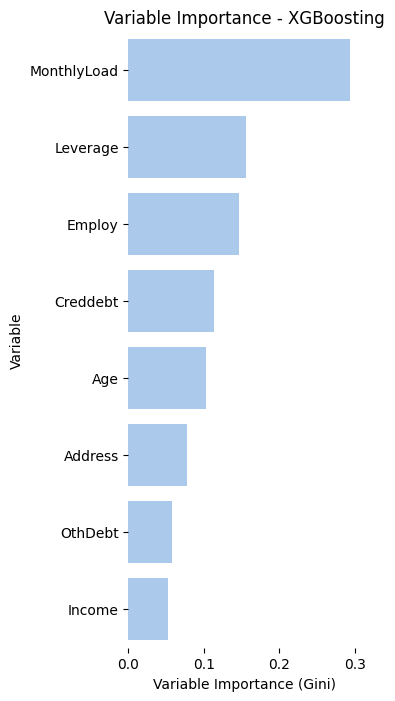

In [35]:
# Plot variable importance
importances = XGB_Bankloan.feature_importances_
indices = np.argsort(importances)[::-1]

f, ax = plt.subplots(figsize=(3, 8))
plt.title("Variable Importance - XGBoosting")
sns.set_color_codes("pastel")
sns.barplot(
    y=[bankloan_train_noWoE.iloc[:, :-1].columns[i] for i in indices],
    x=importances[indices],
    label="Total",
    color="b",
)
ax.set(ylabel="Variable", xlabel="Variable Importance (Gini)")
sns.despine(left=True, bottom=True)


What do you see here? Does it make sense to you?

When the correlation between the variables are high, XGBoost will pick one feature and may use it while breaking down the tree and it will ignore some/all the other remaining correlated features (because we will not be able to learn different aspects of the model by using these correlated feature because it is already highly correlated with the chosen feature). But in random forest , the tree is not built from specific features, rather there is random selection of features, and then the model in whole learn different correlations of different features. So you can see the procedure of two methods are different so you can expect to see different feature importance reports. Also, one needs to check default arguments of each method for calculation of FI. For example, XGBoost's default measure is average gain whereas it is total gain in sklearn. 

Let's finish by plotting the ROC curve. How does it compare to Random Forest? Why do you think this is?

In general, boosting methods work better for small datasets with fewer features.  

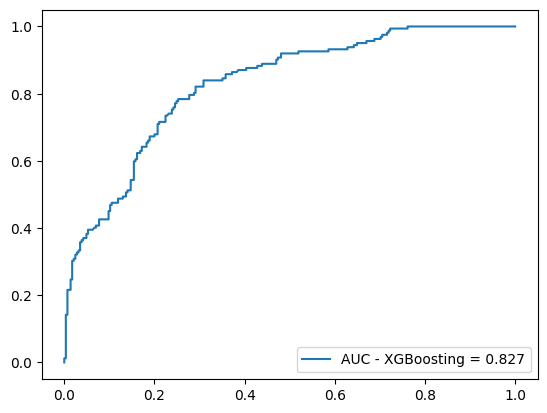

In [36]:
# Calculate probability
probTest = XGB_Bankloan.predict_proba(bankloan_test_noWoE.iloc[:, :-1])
probTest = probTest[:, 1]

# Calculate the ROC curve points
fpr, tpr, thresholds = roc_curve(bankloan_test_noWoE["Default"], probTest)

# Save the AUC in a variable to display it. Round it first
auc = np.round(
    roc_auc_score(y_true=bankloan_test_noWoE["Default"], y_score=probTest), decimals=3
)

# Create and show the plot
plt.plot(fpr, tpr, label="AUC - XGBoosting = " + str(auc))
plt.legend(loc=4)
plt.show()
